## Install pySpark in Google Colab

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.2.3/spark-3.2.3-bin-hadoop2.7.tgz
!tar xf spark-3.2.3-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
#All imports
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.3-bin-hadoop2.7"

## Imports

In [ ]:
import findspark
findspark.init()
from google.colab import files
from pyspark import SparkContext, SparkConf,SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, lit
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
#Small printing
%precision 2
np.set_printoptions(precision=2)

## Crete Spark and SQL Contexts

In [ ]:
# create sparksession and sparkcontext
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

In [ ]:
sqlContext = SQLContext(sc)

## Import Google Drive

In [ ]:
#Mount Google drive, read local file. The file was previously uploaded to Google Drive
from google.colab import drive
drive.mount("/content/drive")
%ls

Mounted at /content/drive
drive/  sample_data/  spark-2.4.8-bin-hadoop2.7/  spark-2.4.8-bin-hadoop2.7.tgz


## Import Data

In [ ]:
path_csv="drive/My Drive/Colab Notebooks/pySpark/Getting Started with PySpark/daily_weather.csv"
df = sqlContext.read.csv(path_csv,header=True,inferSchema=True)
#df = spark.read.csv(path_csv,header=True,inferSchema=True).coalesce(2)
#df=spark.read.format("csv").option("header","true").option("inferSchema","true").option("minPartitions",2).load(path_csv)
df.show(10)

+------+-----------------+------------------+----------------------+------------------+----------------------+------------------+---------------------+-----------------+---------------------+---------------------+
|number| air_pressure_9am|      air_temp_9am|avg_wind_direction_9am|avg_wind_speed_9am|max_wind_direction_9am|max_wind_speed_9am|rain_accumulation_9am|rain_duration_9am|relative_humidity_9am|relative_humidity_3pm|
+------+-----------------+------------------+----------------------+------------------+----------------------+------------------+---------------------+-----------------+---------------------+---------------------+
|     0|918.0600000000087| 74.82200000000041|                 271.1| 2.080354199999768|    295.39999999999986| 2.863283199999908|                  0.0|              0.0|    42.42000000000046|   36.160000000000494|
|     1|917.3476881177097| 71.40384263106537|    101.93517935618371|2.4430092157340217|    140.47154847112498|3.5333236016106238|               

In [ ]:
pd_df = pd.read_csv('https://raw.githubusercontent.com/rramirez-tec-mx/data/main/daily_weather.csv')
df = spark.createDataFrame(pd_df)
df.printSchema()

## Review Spark Configuration
This will show how the cluster is constructed

In [ ]:
df.rdd.getNumPartitions()

1

In [ ]:
print(sc.defaultParallelism)

2


## Explore Data

In [ ]:
df.columns

['number',
 'air_pressure_9am',
 'air_temp_9am',
 'avg_wind_direction_9am',
 'avg_wind_speed_9am',
 'max_wind_direction_9am',
 'max_wind_speed_9am',
 'rain_accumulation_9am',
 'rain_duration_9am',
 'relative_humidity_9am',
 'relative_humidity_3pm']

In [ ]:
df.printSchema()

root
 |-- number: integer (nullable = true)
 |-- air_pressure_9am: double (nullable = true)
 |-- air_temp_9am: double (nullable = true)
 |-- avg_wind_direction_9am: double (nullable = true)
 |-- avg_wind_speed_9am: double (nullable = true)
 |-- max_wind_direction_9am: double (nullable = true)
 |-- max_wind_speed_9am: double (nullable = true)
 |-- rain_accumulation_9am: double (nullable = true)
 |-- rain_duration_9am: double (nullable = true)
 |-- relative_humidity_9am: double (nullable = true)
 |-- relative_humidity_3pm: double (nullable = true)



## Statistical Data Analysis

In [ ]:
df.describe("number","air_pressure_9am","air_temp_9am").show()
#df.describe()

+-------+------------------+-----------------+------------------+
|summary|            number| air_pressure_9am|      air_temp_9am|
+-------+------------------+-----------------+------------------+
|  count|              1095|             1092|              1090|
|   mean|             547.0|918.8825513138094| 64.93300141287072|
| stddev|316.24357700987383|3.184161180386833|11.175514003175877|
|    min|                 0|907.9900000000024|36.752000000000685|
|    max|              1094|929.3200000000012| 98.90599999999992|
+-------+------------------+-----------------+------------------+



In [ ]:
df.select('air_pressure_9am').describe().show()

+-------+-----------------+
|summary| air_pressure_9am|
+-------+-----------------+
|  count|             1092|
|   mean|918.8825513138094|
| stddev|3.184161180386833|
|    min|907.9900000000024|
|    max|929.3200000000012|
+-------+-----------------+



In [ ]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
number,1095,547.0,316.24357700987383,0,1094
air_pressure_9am,1092,918.8825513138094,3.184161180386833,907.9900000000024,929.3200000000012
air_temp_9am,1090,64.93300141287072,11.175514003175877,36.752000000000685,98.90599999999992
avg_wind_direction_9am,1091,142.2355107005759,69.13785928889189,15.500000000000046,343.4
avg_wind_speed_9am,1092,5.50828424225493,4.5528134655317185,0.69345139999974,23.554978199999763
max_wind_direction_9am,1092,148.95351796516923,67.23801294602953,28.89999999999991,312.19999999999993
max_wind_speed_9am,1091,7.019513529175272,5.598209170780958,1.1855782000000479,29.84077959999996
rain_accumulation_9am,1089,0.20307895225211126,1.5939521253574893,0.0,24.01999999999907
rain_duration_9am,1092,294.1080522756142,1598.0787786601481,0.0,17704.0


In [ ]:
#Determine nulls. Where and filter are synonims
# where
print(df.where(col("air_temp_9am").isNull()).count())
# filter
print(df.filter(col("rain_accumulation_9am").isNull()).count())

5
6


In [ ]:
quantiles_air_pressure_9am  = df.approxQuantile("air_pressure_9am",[0.25, 0.5, 0.75], 0)
quantile_25 = quantiles_air_pressure_9am [0]
quantile_50 = quantiles_air_pressure_9am [1]
quantile_75 = quantiles_air_pressure_9am [2]
print('quantile_25: '+str(quantile_25))
print('quantile_50: '+str(quantile_50))
print('quantile_75: '+str(quantile_75))

quantile_25: 916.550000000009
quantile_50: 918.9020905167166
quantile_75: 921.1600000000036


In [ ]:
quantiles = df.approxQuantile(df.columns,[0.25, 0.5, 0.75], 0)
for i in range(len(df.columns)):
  print("Cuantiles " + str(df.columns[i]) + ": " + str(quantiles[0]))  

Cuantiles number: [273.0, 547.0, 821.0]
Cuantiles air_pressure_9am: [273.0, 547.0, 821.0]
Cuantiles air_temp_9am: [273.0, 547.0, 821.0]
Cuantiles avg_wind_direction_9am: [273.0, 547.0, 821.0]
Cuantiles avg_wind_speed_9am: [273.0, 547.0, 821.0]
Cuantiles max_wind_direction_9am: [273.0, 547.0, 821.0]
Cuantiles max_wind_speed_9am: [273.0, 547.0, 821.0]
Cuantiles rain_accumulation_9am: [273.0, 547.0, 821.0]
Cuantiles rain_duration_9am: [273.0, 547.0, 821.0]
Cuantiles relative_humidity_9am: [273.0, 547.0, 821.0]
Cuantiles relative_humidity_3pm: [273.0, 547.0, 821.0]


In [ ]:
pd.DataFrame(data=quantiles, index=df.columns,columns=[0.25, 0.5, 0.75])

,0.25,0.50,0.75
number,273.000000,547.000000,821.000000
air_pressure_9am,916.550000,918.902091,921.160000
air_temp_9am,57.272000,65.696000,73.454000
avg_wind_direction_9am,65.880616,166.000000,191.100000
avg_wind_speed_9am,2.248279,3.869906,7.337163
max_wind_direction_9am,76.456663,177.100000,201.200000
max_wind_speed_9am,3.064608,4.943637,8.970129
rain_accumulation_9am,0.000000,0.000000,0.000000
rain_duration_9am,0.000000,0.000000,0.000000
relative_humidity_9am,15.090000,23.179259,45.590000


#Correlation

There is a correlation function in the ml subpackage pyspark.ml.stat. However, it requires you to provide a column of type Vector. So you need to convert your columns into a vector column first using the VectorAssembler and then apply the correlation:

In [ ]:
from pyspark.mllib.stat import Statistics

df_features = df.drop("number")

# select variables to check correlation
df_features = df.select(df_features.columns).dropna() 

# create RDD table for correlation calculation
rdd_table = df_features.rdd.map(lambda row: row[0:])

# get the correlation matrix
corr_mat=Statistics.corr(rdd_table, method="pearson")
print(corr_mat)

[[ 1.00e+00 -5.73e-02 -3.13e-01  2.36e-01 -2.87e-01  2.52e-01 -8.54e-02
  -1.00e-01 -4.31e-01 -4.80e-01]
 [-5.73e-02  1.00e+00 -1.51e-02 -2.84e-01 -7.95e-02 -2.82e-01 -1.99e-01
  -2.59e-01 -5.82e-01 -4.91e-01]
 [-3.13e-01 -1.51e-02  1.00e+00 -4.41e-01  8.69e-01 -4.60e-01  1.18e-01
   1.27e-01  3.47e-01  3.85e-01]
 [ 2.36e-01 -2.84e-01 -4.41e-01  1.00e+00 -3.64e-01  9.95e-01  2.32e-03
   1.21e-02 -9.55e-02 -1.54e-01]
 [-2.87e-01 -7.95e-02  8.69e-01 -3.64e-01  1.00e+00 -3.83e-01  9.10e-02
   8.26e-02  3.69e-01  4.06e-01]
 [ 2.52e-01 -2.82e-01 -4.60e-01  9.95e-01 -3.83e-01  1.00e+00 -3.34e-04
   1.19e-02 -1.09e-01 -1.74e-01]
 [-8.54e-02 -1.99e-01  1.18e-01  2.32e-03  9.10e-02 -3.34e-04  1.00e+00
   7.36e-01  2.29e-01  1.82e-01]
 [-1.00e-01 -2.59e-01  1.27e-01  1.21e-02  8.26e-02  1.19e-02  7.36e-01
   1.00e+00  3.05e-01  2.63e-01]
 [-4.31e-01 -5.82e-01  3.47e-01 -9.55e-02  3.69e-01 -1.09e-01  2.29e-01
   3.05e-01  1.00e+00  8.81e-01]
 [-4.80e-01 -4.91e-01  3.85e-01 -1.54e-01  4.06e-01 -1.

In [ ]:
corr_mat_pd = pd.DataFrame(data=corr_mat, index=df_features.columns,columns=df_features.columns)
corr_mat_pd

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am,relative_humidity_9am,relative_humidity_3pm
air_pressure_9am,1.000000,-0.057329,-0.313360,0.235826,-0.287280,0.252479,-0.085434,-0.100485,-0.431126,-0.480117
air_temp_9am,-0.057329,1.000000,-0.015069,-0.284327,-0.079520,-0.282483,-0.199102,-0.259103,-0.582318,-0.491068
avg_wind_direction_9am,-0.313360,-0.015069,1.000000,-0.441441,0.868837,-0.460122,0.117634,0.127367,0.346865,0.384885
avg_wind_speed_9am,0.235826,-0.284327,-0.441441,1.000000,-0.364338,0.995412,0.002322,0.012057,-0.095472,-0.154422
max_wind_direction_9am,-0.287280,-0.079520,0.868837,-0.364338,1.000000,-0.383025,0.091003,0.082574,0.369500,0.405946
max_wind_speed_9am,0.252479,-0.282483,-0.460122,0.995412,-0.383025,1.000000,-0.000334,0.011890,-0.108673,-0.173720
rain_accumulation_9am,-0.085434,-0.199102,0.117634,0.002322,0.091003,-0.000334,1.000000,0.735737,0.228951,0.181887
rain_duration_9am,-0.100485,-0.259103,0.127367,0.012057,0.082574,0.011890,0.735737,1.000000,0.304828,0.263283
relative_humidity_9am,-0.431126,-0.582318,0.346865,-0.095472,0.369500,-0.108673,0.228951,0.304828,1.000000,0.881301
relative_humidity_3pm,-0.480117,-0.491068,0.384885,-0.154422,0.405946,-0.173720,0.181887,0.263283,0.881301,1.000000


In [ ]:
corr_mat_sp=Statistics.corr(rdd_table, method="spearman")
corr_mat_pd_sp = pd.DataFrame(data=corr_mat_sp, index=df_features.columns,columns=df_features.columns)
corr_mat_pd_sp

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am,relative_humidity_9am,relative_humidity_3pm
air_pressure_9am,1.000000,-0.117418,-0.279479,0.232753,-0.243158,0.248009,-0.063062,0.000697,-0.472377,-0.527897
air_temp_9am,-0.117418,1.000000,0.021986,-0.360481,-0.040398,-0.364843,-0.227157,-0.286164,-0.424956,-0.359926
avg_wind_direction_9am,-0.279479,0.021986,1.000000,-0.377934,0.859601,-0.392063,0.142616,0.039965,0.335965,0.408805
avg_wind_speed_9am,0.232753,-0.360481,-0.377934,1.000000,-0.299334,0.993435,0.082594,0.210421,-0.105392,-0.205306
max_wind_direction_9am,-0.243158,-0.040398,0.859601,-0.299334,1.000000,-0.309779,0.129086,0.043627,0.336457,0.394171
max_wind_speed_9am,0.248009,-0.364843,-0.392063,0.993435,-0.309779,1.000000,0.080661,0.212161,-0.112784,-0.218481
rain_accumulation_9am,-0.063062,-0.227157,0.142616,0.082594,0.129086,0.080661,1.000000,0.846628,0.286516,0.238172
rain_duration_9am,0.000697,-0.286164,0.039965,0.210421,0.043627,0.212161,0.846628,1.000000,0.206381,0.150008
relative_humidity_9am,-0.472377,-0.424956,0.335965,-0.105392,0.336457,-0.112784,0.286516,0.206381,1.000000,0.866784
relative_humidity_3pm,-0.527897,-0.359926,0.408805,-0.205306,0.394171,-0.218481,0.238172,0.150008,0.866784,1.000000


In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

df_dropped = df.na.drop()
df_dropped = df_dropped.drop("number")
df_columns2 = df_dropped.columns

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_dropped.columns, outputCol=vector_col)
df_vector = assembler.transform(df_dropped).select(vector_col)

# get correlation matrix
r1 = Correlation.corr(df_vector, vector_col)
print("Pearson Corr Matrix\n",r1.collect()[0]["pearson({})".format(vector_col)].values)

r2 = Correlation.corr(df_vector, vector_col, "spearman")
print("Spearman Corr Matrix\n",r2.collect()[0]["spearman({})".format(vector_col)].values)

Pearson Corr Matrix
 [ 1.00e+00 -5.73e-02 -3.13e-01  2.36e-01 -2.87e-01  2.52e-01 -8.54e-02
 -1.00e-01 -4.31e-01 -4.80e-01 -5.73e-02  1.00e+00 -1.51e-02 -2.84e-01
 -7.95e-02 -2.82e-01 -1.99e-01 -2.59e-01 -5.82e-01 -4.91e-01 -3.13e-01
 -1.51e-02  1.00e+00 -4.41e-01  8.69e-01 -4.60e-01  1.18e-01  1.27e-01
  3.47e-01  3.85e-01  2.36e-01 -2.84e-01 -4.41e-01  1.00e+00 -3.64e-01
  9.95e-01  2.32e-03  1.21e-02 -9.55e-02 -1.54e-01 -2.87e-01 -7.95e-02
  8.69e-01 -3.64e-01  1.00e+00 -3.83e-01  9.10e-02  8.26e-02  3.69e-01
  4.06e-01  2.52e-01 -2.82e-01 -4.60e-01  9.95e-01 -3.83e-01  1.00e+00
 -3.34e-04  1.19e-02 -1.09e-01 -1.74e-01 -8.54e-02 -1.99e-01  1.18e-01
  2.32e-03  9.10e-02 -3.34e-04  1.00e+00  7.36e-01  2.29e-01  1.82e-01
 -1.00e-01 -2.59e-01  1.27e-01  1.21e-02  8.26e-02  1.19e-02  7.36e-01
  1.00e+00  3.05e-01  2.63e-01 -4.31e-01 -5.82e-01  3.47e-01 -9.55e-02
  3.69e-01 -1.09e-01  2.29e-01  3.05e-01  1.00e+00  8.81e-01 -4.80e-01
 -4.91e-01  3.85e-01 -1.54e-01  4.06e-01 -1.74e-01  1.82

In [ ]:
pearson_corr_arr = np.matrix(r1.collect()[0]["pearson({})".format(vector_col)].values).reshape(len(df.columns)-1, len(df.columns)-1)
pearson_corr_df = pd.DataFrame(data=pearson_corr_arr, index=df_columns2,columns=df_columns2)
pearson_corr_df

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am,relative_humidity_9am,relative_humidity_3pm
air_pressure_9am,1.000000,-0.057329,-0.313360,0.235826,-0.287280,0.252479,-0.085434,-0.100485,-0.431126,-0.480117
air_temp_9am,-0.057329,1.000000,-0.015069,-0.284327,-0.079520,-0.282483,-0.199102,-0.259103,-0.582318,-0.491068
avg_wind_direction_9am,-0.313360,-0.015069,1.000000,-0.441441,0.868837,-0.460122,0.117634,0.127367,0.346865,0.384885
avg_wind_speed_9am,0.235826,-0.284327,-0.441441,1.000000,-0.364338,0.995412,0.002322,0.012057,-0.095472,-0.154422
max_wind_direction_9am,-0.287280,-0.079520,0.868837,-0.364338,1.000000,-0.383025,0.091003,0.082574,0.369500,0.405946
max_wind_speed_9am,0.252479,-0.282483,-0.460122,0.995412,-0.383025,1.000000,-0.000334,0.011890,-0.108673,-0.173720
rain_accumulation_9am,-0.085434,-0.199102,0.117634,0.002322,0.091003,-0.000334,1.000000,0.735737,0.228951,0.181887
rain_duration_9am,-0.100485,-0.259103,0.127367,0.012057,0.082574,0.011890,0.735737,1.000000,0.304828,0.263283
relative_humidity_9am,-0.431126,-0.582318,0.346865,-0.095472,0.369500,-0.108673,0.228951,0.304828,1.000000,0.881301
relative_humidity_3pm,-0.480117,-0.491068,0.384885,-0.154422,0.405946,-0.173720,0.181887,0.263283,0.881301,1.000000


In [ ]:
import plotly.express as px

fig = px.imshow(pearson_corr_arr)
fig.show()

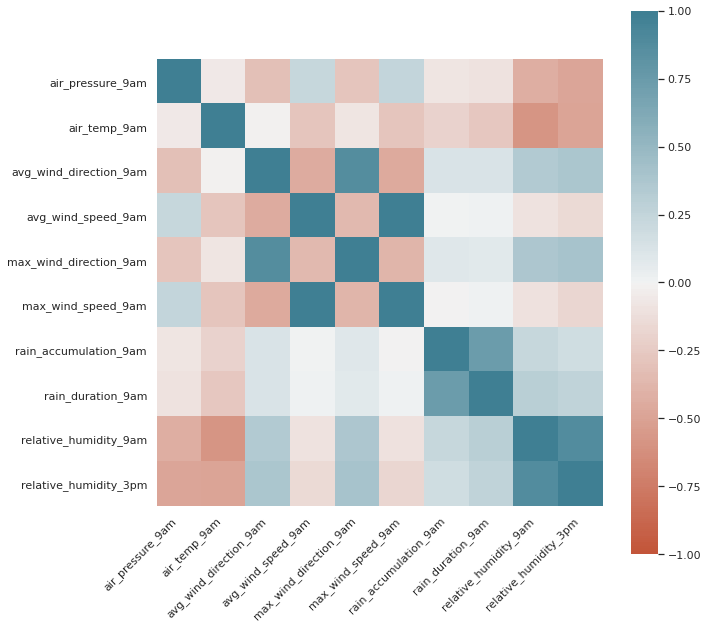

In [ ]:
import seaborn as sns
sns.set(color_codes=True, font_scale=1.0)
from matplotlib import pyplot as plt

#Establecer el tamaño de la figura
plt.figure(figsize=(10,10))

ax = sns.heatmap(
    pearson_corr_df, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

#La barra de anotación
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
!pip install heatmapz

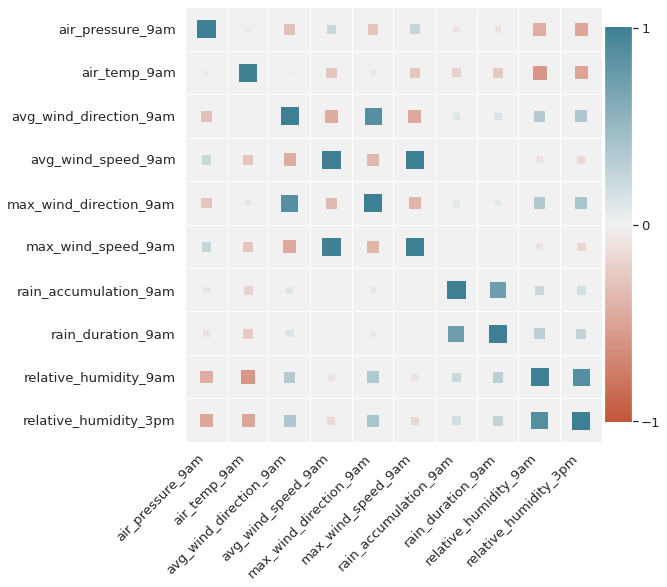

In [ ]:
# Import the two methods from heatmap library
from heatmap import corrplot

plt.figure(figsize=(8, 8))
corrplot(pearson_corr_df ,size_scale=300);

#Sampling RDDs and Spark DataFrames

In [ ]:
#Create and RDD
rdd = sc.parallelize(range(0, 10))
rdd.take(10)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
#Sampling with replacement
rdd.takeSample(True, 20, 1)

[0, 6, 3, 4, 3, 1, 3, 7, 3, 5, 3, 0, 0, 9, 6, 5, 7, 9, 4, 7]

In [ ]:
#Sampling without replacement
rdd.takeSample(False, 5, 2)

[5, 9, 3, 4, 6]

In [ ]:
#Trying to sample more elements than exiting ones
rdd.takeSample(False, 15, 3)

[1, 5, 6, 0, 9, 4, 7, 2, 8, 3]

In [ ]:
#RDDs also have sample primitive using a fraction. Sampling half
rdd.sample(False, 0.5).take(5)

[0, 1, 3, 4, 8]

In [ ]:
rdd.sample(False, 0.5).take(5)

[1, 2, 4, 5, 6]

In [ ]:
rdd.sample(False, 0.5).take(5)

[0, 4, 6, 7]

In [ ]:
df = spark.range(10)
df.show()

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
+---+



In [ ]:
df.sample(withReplacement=False, fraction=0.5, seed=1).show()

+---+
| id|
+---+
|  0|
|  2|
|  3|
|  5|
|  6|
|  7|
|  8|
|  9|
+---+



In [ ]:
df.sample(withReplacement=True, fraction=0.5, seed=1).show()

+---+
| id|
+---+
|  0|
|  2|
|  3|
|  4|
+---+



In [ ]:
df.sample(withReplacement=False, fraction=0.5, seed=2).show()

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
|  5|
|  7|
+---+



In [ ]:
df.sample(withReplacement=False, fraction=0.5, seed=3).show()

+---+
| id|
+---+
|  0|
|  2|
|  9|
+---+



#Graphical Data Analysis

In [ ]:
#Create a Boxplot
#Separate data
df_air_temp_9am=df.select("air_temp_9am")
df_air_temp_9am=df_air_temp_9am.na.drop()
df_air_temp_9am.show()

+------------------+
|      air_temp_9am|
+------------------+
| 74.82200000000041|
| 71.40384263106537|
|60.637999999998776|
| 70.13889486830053|
| 44.29400000000284|
| 78.40400000000422|
| 70.04330431686239|
|51.710000000002346|
| 80.58200000000384|
|  47.4979999999998|
|  77.0360000000015|
| 45.71599999999757|
| 49.78399999999978|
| 62.43799999999798|
| 86.43199999999833|
| 70.86526349026626|
| 77.01896058080769|
| 67.08200000000228|
|  68.5759999999986|
| 62.96438311633252|
+------------------+
only showing top 20 rows



In [ ]:
df_air_temp_9am.count()

1090

In [ ]:
#Separate data, drop NAs and convert to array
df_air_temp_9am=df.select("air_temp_9am")
df_air_temp_9am=df_air_temp_9am.na.drop()
df_air_temp_9am=df_air_temp_9am.rdd.map(lambda row : row.air_temp_9am)
arr_air_temp_9am=df_air_temp_9am.collect()
df_air_temp_9am.take(10)

[74.82, 71.40, 60.64, 70.14, 44.29, 78.40, 70.04, 51.71, 80.58, 47.50]

In [ ]:
%matplotlib inline

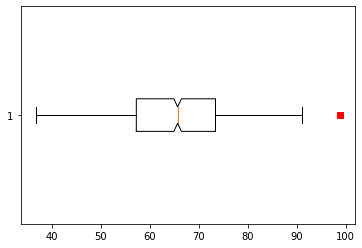

In [ ]:
#Boxplot
import matplotlib.pyplot as plt
#pd_air_temp_9am=df_air_temp_9am.toPandas()
#vanilla
#plt.boxplot(arr_air_temp_9am)
#With waist=1, without waist=0
#plt.boxplot(arr_air_temp_9am,1)
#change outlayer points "green diamonds"
#plt.boxplot(arr_air_temp_9am,1,"gD")
#Horizontal=0, vertical=1
plt.boxplot(arr_air_temp_9am,1,"rs",0)
plt.show()

In [ ]:
#Create a histogram
import plotly.express as px
fig = px.histogram(x=arr_air_temp_9am,labels={'x':'air temp 9am', 'y':'Frecuencia'})
#fig.xlabel("air temp 9am")
#fig = px.histogram(arr_air_temp_9am,nbins = 10)
fig.show()

In [ ]:
#Now we develop grouped box plot. Observe mean air temp 9am is 65 
df_nona=df.na.drop()
df_nona.createOrReplaceTempView("Weather")
query='SELECT relative_humidity_9am from Weather where air_temp_9am>65'
df_people_names = spark.sql(query)
df_people_names.show(10)

+---------------------+
|relative_humidity_9am|
+---------------------+
|    42.42000000000046|
|   24.328697291802207|
|   12.189101868764444|
|   35.130000000000265|
|   10.657421657822635|
|    29.58000000000045|
|   22.070000000000228|
|   15.189999999999962|
|   12.110889335294598|
|   21.031461768790646|
+---------------------+
only showing top 10 rows



In [ ]:
#Verify split
from pyspark.sql.functions import col
df_nona=df.na.drop()
# 2 Apply the transformation and add it to the DataFrame
df_nona = df_nona.withColumn("air_temp_by_rel_hum", col("air_temp_9am")>65)
#df_nona.printSchema()
df_nona.show()

+------+-----------------+------------------+----------------------+------------------+----------------------+------------------+---------------------+-----------------+---------------------+---------------------+-------------------+
|number| air_pressure_9am|      air_temp_9am|avg_wind_direction_9am|avg_wind_speed_9am|max_wind_direction_9am|max_wind_speed_9am|rain_accumulation_9am|rain_duration_9am|relative_humidity_9am|relative_humidity_3pm|air_temp_by_rel_hum|
+------+-----------------+------------------+----------------------+------------------+----------------------+------------------+---------------------+-----------------+---------------------+---------------------+-------------------+
|     0|918.0600000000087| 74.82200000000041|                 271.1| 2.080354199999768|    295.39999999999986| 2.863283199999908|                  0.0|              0.0|    42.42000000000046|   36.160000000000494|               true|
|     1|917.3476881177097| 71.40384263106537|    101.93517935618

In [ ]:
df_grouped_rel_hum = df_nona.groupby("air_temp_by_rel_hum")
#print(df_grouped_5rel_hum)
df_grouped_rel_hum.count().show()

+-------------------+-----+
|air_temp_by_rel_hum|count|
+-------------------+-----+
|               true|  558|
|              false|  506|
+-------------------+-----+



In [ ]:
#Divide data
df_gt_65=df_nona.filter(df_nona["air_temp_9am"]>65) 
df_lt_65=df_nona.filter(df_nona["air_temp_9am"]<=65) 
#df_gt_65.take(10)

In [ ]:
#Extract variable of interest
df_gt65_humidity=df_gt_65.select("relative_humidity_9am")
df_lt65_humidity=df_lt_65.select("relative_humidity_9am")

In [ ]:
#Convert to array
df_gt65_humidity=df_gt65_humidity.rdd.map(lambda row : row.relative_humidity_9am)
arr_gt65_humidity=df_gt65_humidity.collect()
df_lt65_humidity=df_lt65_humidity.rdd.map(lambda row : row.relative_humidity_9am)
arr_lt65_humidity=df_lt65_humidity.collect()

Text(0.5, 1.0, 'air humidity 9am')

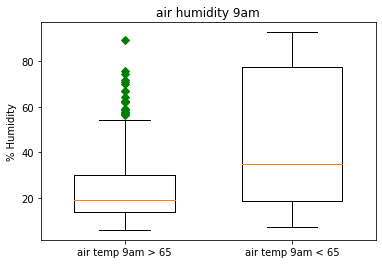

In [ ]:
#Boxplots
fig, ax = plt.subplots()
ax.boxplot(arr_gt65_humidity,0,"gD",positions = [1], widths = 0.6)
ax.boxplot(arr_lt65_humidity,0,"bx",positions = [2], widths = 0.6)

ax.set_xticklabels(['air temp 9am > 65', 'air temp 9am < 65'])
ax.set_ylabel('% Humidity')
ax.set_title('air humidity 9am')

In [ ]:
#Now we develop a scatter plot
#Select data
df_nona=df.na.drop()
df_temp_9am=df_nona.select("air_temp_9am")
df_humidity_9am=df_nona.select("relative_humidity_9am")
print(df_temp_9am.count(),df_humidity_9am.count())
#print(df_temp_9am)

1064 1064


In [ ]:
#Convert to array
df_temp_9am=df_temp_9am.rdd.map(lambda row : row.air_temp_9am)
df_humidity_9am=df_humidity_9am.rdd.map(lambda row : row.relative_humidity_9am)
arr_temp_9am=df_temp_9am.collect()
arr_humidity_9am=df_humidity_9am.collect()
#print(len(arr_temp_9am),len(arr_humidity_9am))

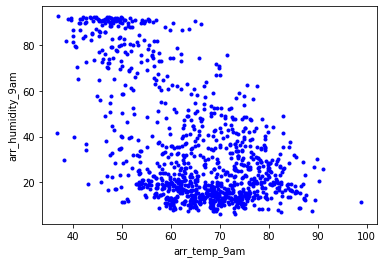

In [ ]:
#Plot
plt.plot(arr_temp_9am,arr_humidity_9am,'b.')
plt.xlabel("arr_temp_9am")
plt.ylabel("arr_humidity_9am")
plt.show()

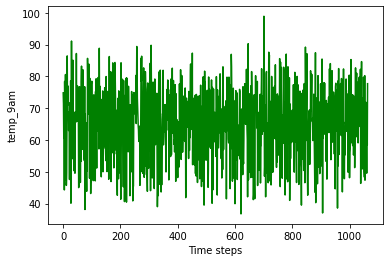

In [ ]:
#Line plot
plt.plot(arr_temp_9am,'g')
plt.xlabel("Time steps")
plt.ylabel("temp_9am")
plt.show()

In [ ]:
#Bar plot
import plotly.express as px
fig=px.bar(x=arr_temp_9am)
fig.update_traces(marker_color='orange',width=0.1)
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    yaxis=dict(
        title_text="air temp 9am",
        ticktext=["Time"],
        tickmode="array",
        titlefont=dict(size=30),
    )
)
fig.show()

In [ ]:
#Create 3D Scatter plot
#Extract info
df_nona=df.na.drop()
df_nona=df_nona.sample(False,0.1)
df_temp_9am=df_nona.select("air_temp_9am")
df_humidity_9am=df_nona.select("relative_humidity_9am")
df_pressure_9am=df_nona.select("air_pressure_9am")

In [ ]:
#Create arrays
df_temp_9am=df_temp_9am.rdd.map(lambda row : row.air_temp_9am)
df_humidity_9am=df_humidity_9am.rdd.map(lambda row : row.relative_humidity_9am)
df_pressure_9am=df_pressure_9am.rdd.map(lambda row : row.air_pressure_9am)
arr_temp_9am=df_temp_9am.collect()
arr_humidity_9am=df_humidity_9am.collect()
arr_pressure_9am=df_pressure_9am.collect()

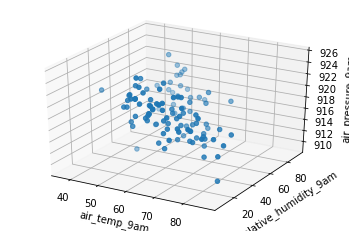

In [ ]:
#Plot 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(arr_temp_9am, arr_humidity_9am, arr_pressure_9am, marker='o')

ax.set_xlabel("air_temp_9am")
ax.set_ylabel("relative_humidity_9am")
ax.set_zlabel("air_pressure_9am")

plt.show()